<a href="https://colab.research.google.com/github/just-benedict-it/GAN/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [77]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cpu")
print("using: ", DEVICE)

EPOCHS = 400
BATCH_SIZE = 200

using:  cpu


In [78]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozila/5.0")]

In [79]:
transformer = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.MNIST(root="/content/drive/MyDrive/MNIST", train=True,
                                      download=True, transform=transformer)

#DataLoder: loader에 전체 trainset을 담고 BATCH_SIZE만큼씩 내보내주는 저장소 역할
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root="/content/drive/MyDrive/MNIST", train=False,
                                     download=True, transform=transformer)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

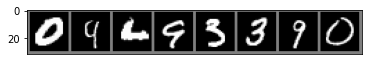

In [80]:
#200개이미지가 담겨있는 trainloader를 iter돌림
#next는 iter중 다음 것 하나만 보여준다.
sample, label = next(iter(trainloader))

def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    img = (img + 1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    ax = plt.gca()
    #matplotlib사용할 때 나오는 좌표계를 보일거냐 안 보일거냐
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(True)
    plt.show()

imshow_grid(sample[0:8])


In [81]:
class Dis_model(nn.Module):
    def __init__(self, image_size, hidden_space):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(image_size, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, 1),
            nn.Sigmoid()
        )
    def forward(self, input_x):
        x = self.features(input_x)
        return x


In [82]:
class Gen_model(nn.Module):
    def __init__(self, latent_space, hidden_space, image_size):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(latent_space, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, image_size),
            nn.Tanh()
        )
    def forward(self, input_x):
        x = self.features(input_x)
        return x


In [83]:
im_size = 784
hidden_size = 256
latent_size = 100

Dis_net = Dis_model(image_size = im_size, hidden_space = hidden_size).to(DEVICE)
# Dis_net = Dis_model(im_size, hidden_size).to(DEVICE)
Gen_net = Gen_model(latent_space=latent_size, hidden_space=hidden_size, image_size=im_size).to(DEVICE)

d_optimizer = optim.Adam(Dis_net.parameters(), lr=0.0002)
g_optimizer = optim.Adam(Gen_net.parameters(), lr=0.0002)

In [84]:
def train(generator, discriminator, train_loader, optimizer_d, optimizer_g):
    generator.train()
    discriminator.train()

    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer_d.zero_grad()
        noise_sample_d = torch.randn(BATCH_SIZE, latent_size).to(DEVICE)

        discri_value = discriminator(data.view(-1,28*28))
        loss_real = -1 * torch.log(discri_value)

        gene_value = discriminator(generator(noise_sample_d))
        loss_fake = -1 * torch.log(1 - gene_value)

        loss_d = (loss_real + loss_fake).mean()

        loss_d.backward()
        optimizer_d.step()

        optimizer_g.zero_grad()
        noise_sample_g = torch.randn(BATCH_SIZE, latent_size).to(DEVICE)

        fake_value = discriminator(generator(noise_sample_g))
        loss_generator = -1 * torch.log(fake_value).mean()

        loss_generator.backward()
        optimizer_g.step()


In [85]:
for epoch in tqdm(range(EPOCHS)):
    train(Gen_net, Dis_net, trainloader, d_optimizer, g_optimizer)

    if (epoch+1)%20 == 0:
        print("epoch %i /400" % (epoch+1))
        noise_sam = torch.randn(16, latent_size).to(DEVICE)
        imshow_grid(Gen_net(noise_sam).view(-1,1,28,28))
        print("\n")


  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

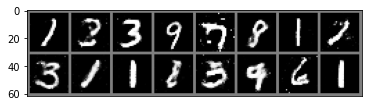

In [76]:
sample_noise = torch.randn(16, latent_size).to(DEVICE)
imshow_grid(Gen_net(sample_noise).view(-1,1,28,28))